In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession


In [7]:
## I probably need a preprocesser function that removes nulls and imputes mean for rest.

In [8]:
cs1 = pd.read_csv('exp/export.csv')
cs2 = pd.read_csv('exp/export(1).csv')
cs3 = pd.read_csv('exp/export(2).csv')
cs4 = pd.read_csv('exp/export(3).csv')
cs5 = pd.read_csv('exp/export(4).csv')

comp = pd.concat([cs1, cs2, cs3, cs4, cs5], axis=0)
comp.head(10)

Prospectus Type                                      Document Type  \
0        Base Prospectus  Final terms, including the  summary of the ind...   
1        Base Prospectus  Final terms, including the  summary of the ind...   
2        Base Prospectus  Final terms, including the  summary of the ind...   
3        Base Prospectus  Final terms, including the  summary of the ind...   
4        Base Prospectus  Final terms, including the  summary of the ind...   
5        Base Prospectus  Final terms, including the  summary of the ind...   
6        Base Prospectus  Final terms, including the  summary of the ind...   
7        Base Prospectus  Final terms, including the  summary of the ind...   
8  Standalone Prospectus                              Standalone prospectus   
9  Standalone Prospectus                              Standalone prospectus   

  Last Passporting Date Approval or filing date Home Member State  \
0                   NaN              24/05/2025           CZECHIA   
1                   NaN              24/04/2025           CZECHIA   
2                   NaN              24/04/2025           CZECHIA   
3                   NaN              24/04/2025           CZECHIA   
4                   NaN              24/04/2025           CZECHIA   
5                   NaN              24/04/2025           CZECHIA   
6                   NaN              24/04/2025           CZECHIA   
7                   NaN              24/04/2025           CZECHIA   
8                   NaN              22/04/2025           CZECHIA   
9                   NaN              22/04/2025           CZECHIA   

                     Securities Type          ISIN First Passporting Date  \
0  Debt with denomination < €100.000  CZ0003572414                    NaN   
1  Debt with denomination < €100.000  CZ0003572273                    NaN   
2  Debt with denomination < €100.000  CZ0003572422                    NaN   
3  Debt with denomination < €100.000  CZ0003572406                    NaN   
4  Debt with denomination < €100.000  CZ0003572042                    NaN   
5  Debt with denomination < €100.000  CZ0003572059                    NaN   
6  Debt with denomination < €100.000  CZ0003572075                    NaN   
7  Debt with denomination < €100.000  CZ0003572067                    NaN   
8                             Shares  CZ0009013272                    NaN   
9                             Shares  CZ1008000831                    NaN   

  Last Update Date National Document ID        Consideration offered  \
0       26/04/2025           FTWS664847                Max 340000000   
1       25/04/2025           FTWS663992                Max 100000000   
2       26/04/2025           FTWS664848                Max 200000000   
3       26/04/2025           FTWS664849                Max 200000000   
4       26/04/2025           FTWS664853                 Max 50000000   
5       26/04/2025           FTWS665000                Max 150000000   
6       26/04/2025           FTWS665001                  Max 1000000   
7       26/04/2025           FTWS664999                Max 100000000   
8       24/04/2025           STDA100844  From 160140000 to 266900000   
9       24/04/2025           STDA100844  From 120000000 to 600000000   

                                Issuer(s) Name / LEI Host Member State(s)  
0  Českomoravská Projektová VII a.s. - 31570006FB...                  NaN  
1           WOOD SEEDS s.r.o. - 3157004CFGD745LKYZ81                  NaN  
2  Českomoravská Projektová VII a.s. - 31570006FB...                  NaN  
3  Českomoravská Projektová VII a.s. - 31570006FB...                  NaN  
4    BICZ Bond 2024 CR s.r.o. - 3157006C8O37QWMV6H25                  NaN  
5    BICZ Bond 2024 CR s.r.o. - 3157006C8O37QWMV6H25                  NaN  
6    BICZ Bond 2024 CR s.r.o. - 3157006C8O37QWMV6H25                  NaN  
7    BICZ Bond 2024 CR s.r.o. - 3157006C8O37QWMV6H25                  NaN  
8      ALEMAR Food Group a.s. - 315700L63KOVVLIKGM26  

In [9]:
len(comp)

5237

In [10]:
a = comp.isna().sum().sort_values(ascending=False)
a

Last Passporting Date      5067
First Passporting Date     5067
Host Member State(s)       4963
Consideration offered      1811
ISIN                       1224
Securities Type             514
Prospectus Type               0
Document Type                 0
Approval or filing date       0
Home Member State             0
Last Update Date              0
National Document ID          0
Issuer(s) Name / LEI          0
dtype: int64

In [11]:
cols_to_drop = a[a >= 4963].keys()

In [12]:
comp = comp.drop(cols_to_drop, axis=1)

In [13]:
comp.dropna(inplace=True)

In [14]:
len(comp)

3415

In [15]:
comp = comp[comp['Consideration offered']!='Not applicable']

In [16]:
comp['Consideration offered'] = comp['Consideration offered'].str.replace('Max','')
comp['Consideration offered'] = comp['Consideration offered']
comp['Last Update Date'] = pd.to_datetime(comp['Last Update Date'])

/var/folders/v1/v83gn92x7vv8phs46b_nj2gr0000gn/T/ipykernel_37318/2841433693.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  comp['Last Update Date'] = pd.to_datetime(comp['Last Update Date'])


In [17]:
s = []
for a in comp['Consideration offered']:
    if "From" in a:
        print(a)
        s.append(a)

len(s)
### kam 129 me interval fromi. per momentin, gjeja me e mir per te ber esht ta bej time series arima me datasetin e timeseries.

From 160140000 to 266900000
From 120000000 to 600000000
From 1750440000 to 2917400000
From 1200000000 to 6000000000
From 2315940000 to 2737020000
From 30000000 to 45000000
From 700000000 to 1000000000
From 3000000 to 3750000
From 50000000 to 75000000
From 80000000 to 1200000000
From 50000000 to 750000000
From 80000000 to 1200000000
From 140000000 to 175000000
From 45000000 to 56250000
From 165000000 to 206250000
From 6000000 to 12000000
From 64725696 to 72238500
From 10538304 to 11761500
From 50000000 to 75000000
From 80000000 to 120000000
From 80000000 to 120000000
From 50000000 to 75000000
From 25000000 to 37500000
From 30000000 to 60000000
From 30000000 to 60000000
From 250000000 to 400000000
From 25000000 to 50000000
From 25000000 to 50000000
From 25000000 to 50000000
From 420000 to 840000
From 420000 to 840000
From 420000 to 840000
From 20000000 to 40000000
From 30000000 to 60000000
From 140000000 to 175000000
From 165000000 to 206250000
From 45000000 to 56250000
From 3000000 to 3

129

In [18]:
comp = comp[comp['Consideration offered'].apply(lambda x: x not in s)]
comp

Prospectus Type                                      Document Type  \
0          Base Prospectus  Final terms, including the  summary of the ind...   
1          Base Prospectus  Final terms, including the  summary of the ind...   
2          Base Prospectus  Final terms, including the  summary of the ind...   
3          Base Prospectus  Final terms, including the  summary of the ind...   
4          Base Prospectus  Final terms, including the  summary of the ind...   
..                     ...                                                ...   
414  Standalone Prospectus                              Standalone prospectus   
415  Standalone Prospectus                              Standalone prospectus   
416  Standalone Prospectus                              Standalone prospectus   
417  Standalone Prospectus                              Standalone prospectus   
422  Standalone Prospectus                              Standalone prospectus   

    Approval or filing date Home Member State  \
0                24/05/2025           CZECHIA   
1                24/04/2025           CZECHIA   
2                24/04/2025           CZECHIA   
3                24/04/2025           CZECHIA   
4                24/04/2025           CZECHIA   
..                      ...               ...   
414              11/02/2021          SLOVAKIA   
415              11/02/2021          SLOVAKIA   
416              29/01/2021          SLOVAKIA   
417              29/01/2021          SLOVAKIA   
422              08/12/2020          SLOVAKIA   

                                       Securities Type          ISIN  \
0                    Debt with denomination < €100.000  CZ0003572414   
1                    Debt with denomination < €100.000  CZ0003572273   
2                    Debt with denomination < €100.000  CZ0003572422   
3                    Debt with denomination < €100.000  CZ0003572406   
4                    Debt with denomination < €100.000  CZ0003572042   
..                                                 ...           ...   
414  Debt with denomination < €100.000 available on...  SK4000018438   
415                  Debt with denomination < €100.000  SK4000018446   
416                  Debt with denomination < €100.000  SK4000018362   
417                  Debt with denomination < €100.000  SK4000018370   
422                                             Shares  SK1000023517   

    Last Update Date National Document ID Consideration offered  \
0         2025-04-26           FTWS664847             340000000   
1         2025-04-25           FTWS663992             100000000   
2         2025-04-26           FTWS664848             200000000   
3         2025-04-26           FTWS664849             200000000   
4         2025-04-26           FTWS664853              50000000   
..               ...                  ...                   ...   
414       2022-02-04     NBS1-000-057-307             550000000   
415       2022-02-11     NBS1-000-057-309             550000000   
416       2022-02-04     NBS1-000-057-127               5000000   
417       2022-02-04     NBS1-000-057-128              10000000   
422       2022-02-11     NBS1-000-055-623               3505300   

                                  Issuer(s) Name / LEI  
0    Českomoravská Projektová VII a.s. - 31570006FB...  
1             WOOD SEEDS s.r.o. - 3157004CFGD745LKYZ81  
2    Českomoravská Projektová VII a.s. - 31570006FB...  
3    Českomoravská Projektová VII a.s. - 31570006FB...  
4      BICZ Bond 2024 CR s.r.o. - 3157006C8O37QWMV6H25  
..                                                 ...  
414            SAB Holding a.s. - 315700W4A4AEAU8O8745  
415            SAB Holding a.s. - 315700W4A4AEAU8O8745  
416  Penta Funding Public II, s.r.o. - 097900BIB000...  
417  Penta Funding Public II, s.r.o. - 097900BIB000...  
422     VINOHRADY HABSBURG a.s. - 097900BIFR0000155297  

[2296 rows x 10 columns]

In [19]:
# esht koha t perdorim sparkun edhe te shofim si punon arima n spark.

In [2]:
spark = SparkSession.builder.appName("ExcelToSpark").getOrCreate()
file1_pd = pd.read_csv("fl1.csv")
file2_pd = pd.read_csv("fl2.csv")

file1_spark = spark.createDataFrame(file1_pd)
file2_spark = spark.createDataFrame(file2_pd)

df_joined = file1_spark.join(file2_spark, on='KEY', how='left')
df_joined.printSchema()
df_joined.show(10)

25/05/15 13:39:09 WARN Utils: Your hostname, Mels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.60.174.145 instead (on interface en0)
25/05/15 13:39:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/15 13:39:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- KEY: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- TITLE_COMPL: double (nullable = true)
 |-- PROSP3_MEASURE: string (nullable = true)
 |-- FREQ: string (nullable = true)
 |-- S_NCA: string (nullable = true)
 |-- PROSP3_SECURITIES_TYPE: string (nullable = true)
 |-- MTR: string (nullable = true)
 |-- CURR_ISSNC: string (nullable = true)
 |-- PROSP3_OFFER_TYPE: string (nullable = true)
 |-- PROSP3_DOCUMENT_TYPE: string (nullable = true)
 |-- SEC_TYPE_CFI: string (nullable = true)
 |-- ISSUER_COU: string (nullable = true)
 |-- ISSUER_SECTOR: string (nullable = true)
 |-- PROSP3_PRSP_TYPE: string (nullable = true)
 |-- PROSP3_SME_CAT_TYPE: string (nullable = true)
 |-- PROSP3_PSSP: string (nullable = true)
 |-- PROSP3_VENUE: string (nullable = true)
 |-- PROSP3_LNGG: string (nullable = true)
 |-- MV: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- TIME_PERIOD: string (nullable = true)
 |-- PK: double (nullable = true)
 |-- OBS_VALUE: doubl

25/05/15 13:39:14 WARN TaskSetManager: Stage 1 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+----------+------------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|        PK|   OBS_VALUE|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+-----

In [21]:
# a duhet ta bej group by cols funksion me vete apo ta le brenda gjerave?? mund ti bej te dyja.
# mund te bej plote diskriptive qe kto te shofin ca po behet.

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

def prepare_grouped_timeseries(df, groupby_cols, date_col='TIME_PERIOD', value_col='OBS_VALUE'):
    df = df.withColumn('parsed_date', F.to_date(F.concat_ws('-', F.split(date_col, '-Q')[0],
                                                             ((F.split(date_col, '-Q')[1].cast('int') - 1) * 3 + 1).cast('string'),
                                                             F.lit('01'))))

    grouped = df.select(*groupby_cols, 'parsed_date', value_col) \
                .orderBy(*groupby_cols, 'parsed_date') \
                .groupBy(*groupby_cols) \
                .agg(F.collect_list(F.struct('parsed_date', value_col)).alias('time_series'))

    return grouped

In [22]:
grouped = prepare_grouped_timeseries(df_joined, ['SEC_TYPE_CFI', 'ISSUER_COU'], date_col='TIME_PERIOD', value_col='OBS_VALUE')

In [23]:
grouped.show(10, truncate=False)

25/05/14 19:32:50 WARN TaskSetManager: Stage 6 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+------------+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
# Get the first group's time series from Spark
row = grouped.collect()[0]
ts_data = row['time_series']

25/05/14 19:32:52 WARN TaskSetManager: Stage 23 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


In [25]:
row

Row(SEC_TYPE_CFI='Z', ISSUER_COU='Z', time_series=[Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1310004990.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1130444670.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=100446208000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=489361375000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=2097586300.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=677652860.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=38.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=61.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1149.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=12.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=14.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1335284.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=2711631950000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1036725760.0), Row(parsed_date=datetime.date(20

In [26]:
pd_grouped = grouped.toPandas()

In [27]:
pd_grouped['time_series']

0      [(2021-01-01, 1310004990.0), (2021-01-01, 1130...
1      [(2021-01-01, 3.0), (2021-01-01, 10.0), (2021-...
2      [(2021-01-01, 25.0), (2021-01-01, 425.0), (202...
3      [(2021-01-01, 35.0), (2021-01-01, 1.0), (2021-...
4      [(2021-01-01, 4.0), (2021-01-01, 11.0), (2021-...
                             ...                        
871    [(2021-07-01, 1.0), (2021-07-01, 1.0), (2021-0...
872    [(2021-04-01, 1.0), (2021-04-01, 1.0), (2021-0...
873    [(2021-01-01, 1.0), (2021-01-01, 1.0), (2021-0...
874    [(2021-10-01, 1.0), (2021-10-01, 1.0), (2021-1...
875    [(2021-01-01, 1.0), (2021-01-01, 7.0), (2021-0...
Name: time_series, Length: 876, dtype: object

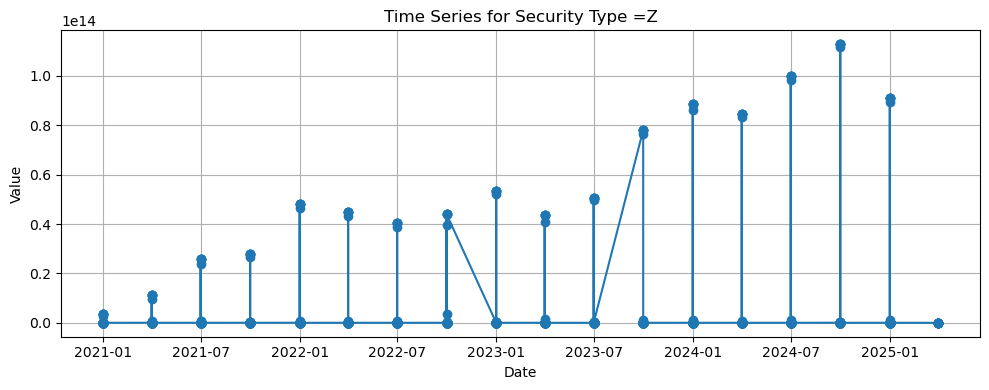

In [28]:
pdf = pd.DataFrame([(r['parsed_date'], r['OBS_VALUE']) for r in ts_data],
                   columns=['date', 'value'])

# Sort and plot
pdf = pdf.sort_values('date')
plt.figure(figsize=(10, 4))
plt.plot(pdf['date'], pdf['value'], marker='o')
plt.title(f"Time Series for Security Type ={row['SEC_TYPE_CFI']}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
grouped_rows = grouped.collect()
num_groups = len(grouped_rows)
num_groups

876

IndexError: index 4 is out of bounds for axis 0 with size 4

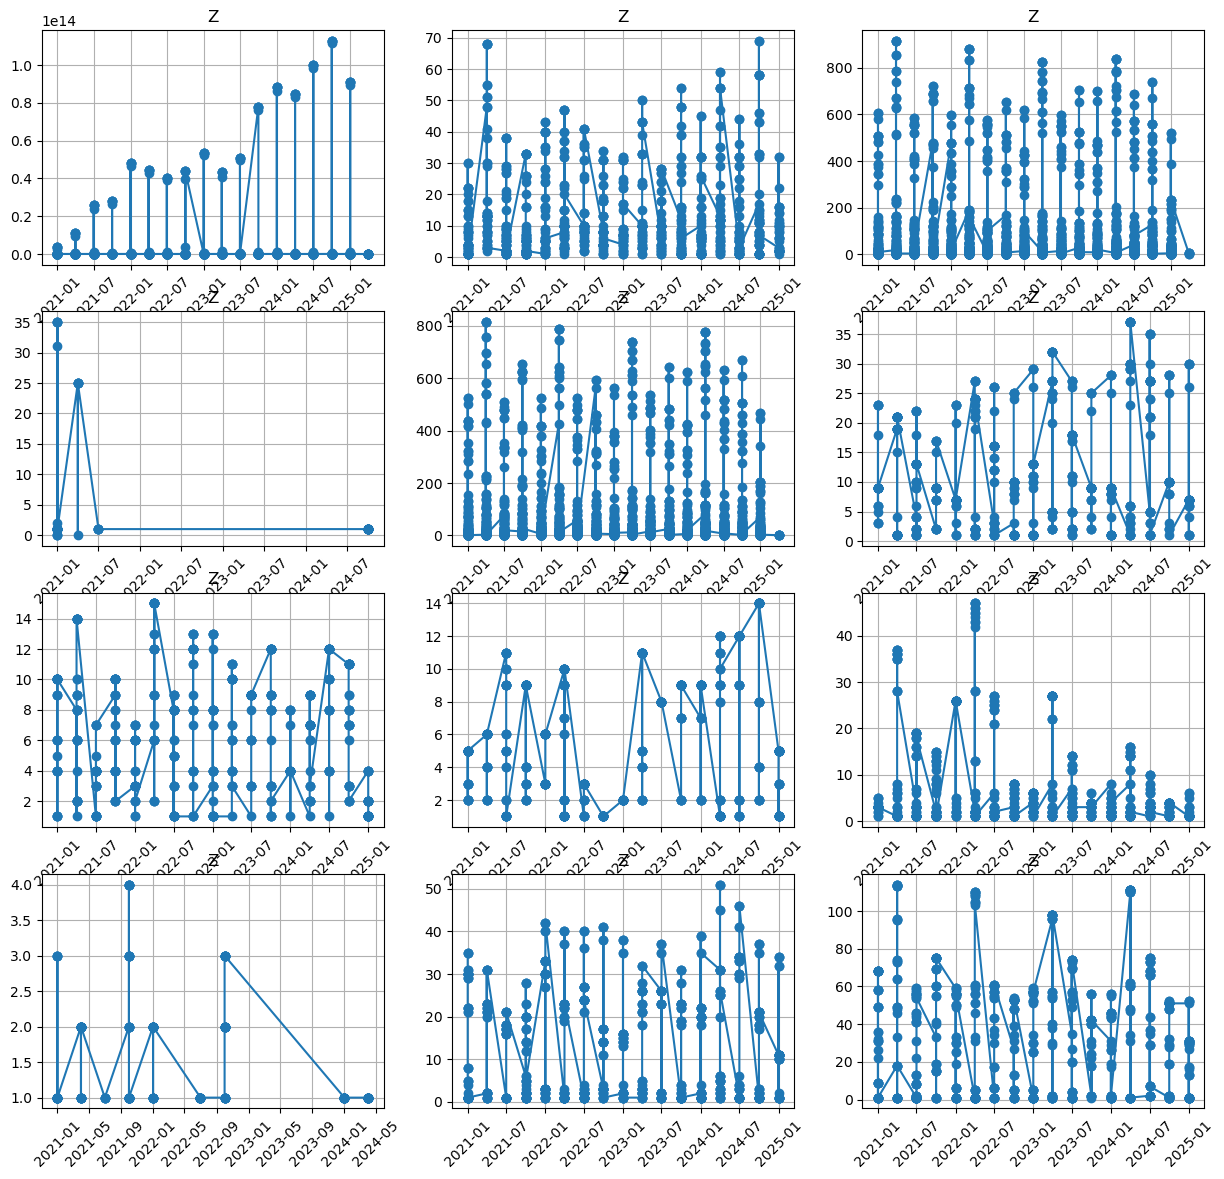

In [38]:
grouped_rows = grouped.collect()
num_groups = len(grouped_rows)
cols = 3
rows = (12 + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.5*rows), squeeze=False)

for idx, row in enumerate(grouped_rows[:13]):
    ts_data = row['time_series']
    group_key = f"{row['SEC_TYPE_CFI']}"

    pdf = pd.DataFrame([(r['parsed_date'], r['OBS_VALUE']) for r in ts_data],
                       columns=['date', 'value']).sort_values('date')

    ax = axes[idx // cols][idx % cols]
    ax.plot(pdf['date'], pdf['value'], marker='o')
    ax.set_title(group_key)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

for i in range(num_groups, rows * cols):
    fig.delaxes(axes[i // cols][i % cols])

plt.tight_layout()
plt.show()

In [35]:
import plotly.express as px
all_data = []

for row in grouped_rows:
    ts = row['time_series']
    sec_type = row['SEC_TYPE_CFI']

    for point in ts:
        all_data.append({
            'date': point['parsed_date'],
            'value': point['OBS_VALUE'],
            'SEC_TYPE_CFI': sec_type,
        })

df_all = pd.DataFrame(all_data)
fig = px.scatter(
    df_all,
    x="date",
    y="value",
    color="SEC_TYPE_CFI",
    title="Interactive Time Series by Security Type",
    labels={"value": "Consideration", "date": "Date"}
)

fig.update_layout(
    width=1000,
    height=600,
    legend=dict(title="Security Type", orientation="v", font=dict(size=10)),
    xaxis=dict(showgrid=True, tickangle=45),
    yaxis=dict(showgrid=True),
    margin=dict(l=40, r=40, t=40, b=40),
)

fig.show()

In [49]:
group_data = []

for row in grouped_rows:
    sec_type = row['SEC_TYPE_CFI']
    country = row['ISSUER_COU']
    ts = row['time_series']

    pdf = pd.DataFrame([(r['parsed_date'], r['OBS_VALUE']) for r in ts],
                       columns=['parsed_date', 'OBS_VALUE']).sort_values('parsed_date')
    pdf['SEC_TYPE_CFI'] = sec_type
    pdf['ISSUER_COU'] = country
    group_data.append(pdf)
df_all = pd.concat(group_data, ignore_index=True)

In [50]:
df_all

parsed_date     OBS_VALUE              SEC_TYPE_CFI ISSUER_COU
0       2021-01-01  1.310005e+09                         Z          Z
1       2021-01-01  2.900000e+01                         Z          Z
2       2021-01-01  1.000000e+00                         Z          Z
3       2021-01-01  1.193761e+06                         Z          Z
4       2021-01-01  1.000000e+00                         Z          Z
...            ...           ...                       ...        ...
152023  2025-01-01  9.000000e+00  [ZNAV] CFI not available  [V5] EU27
152024  2025-01-01  1.000000e+00  [ZNAV] CFI not available  [V5] EU27
152025  2025-01-01  1.500000e+01  [ZNAV] CFI not available  [V5] EU27
152026  2025-01-01  1.500000e+01  [ZNAV] CFI not available  [V5] EU27
152027  2025-01-01  1.500000e+01  [ZNAV] CFI not available  [V5] EU27

[152028 rows x 4 columns]

In [ ]:
import warnings
import os
from pmdarima import auto_arima

warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np

def check_stationarity_and_fit(ts_raw, m=4, do_log=True):
    """
    ts_raw : pandas.Series indexed by date
    m      : seasonal period (4 for quarterly)
    do_log : whether to log‐transform first
    """

    # Optional log‐transform
    ts = np.log(ts_raw) if do_log and (ts_raw > 0).all() else ts_raw.copy()
    label = "log" if do_log else "raw"

    # Plot & decompose
    fig, ax = plt.subplots(4,1, figsize=(10,8), sharex=True)
    ts.plot(ax=ax[0], title=f"{label} series")
    res = seasonal_decompose(ts, model='additive', period=m)
    ax[1].plot(res.trend);    ax[1].set_title("Trend")
    ax[2].plot(res.seasonal); ax[2].set_title("Seasonal")
    ax[3].plot(res.resid);    ax[3].set_title("Residual")
    plt.tight_layout(); plt.show()

    # ADF on raw/log series
    p_raw = adfuller(ts.dropna())[1]
    print(f"ADF on {label}: p = {p_raw:.4f}")

    # First difference
    diff1 = ts.diff().dropna()
    p_diff1 = adfuller(diff1)[1]
    print(f"ADF on 1st‐diff: p = {p_diff1:.4f}")

    # Seasonal difference
    diff_seasonal = diff1.diff(m).dropna()
    p_seas = adfuller(diff_seasonal)[1]
    print(f"ADF on (1st‐diff, {m}‐lag diff): p = {p_seas:.4f}")

    # KPSS as a cross-check (stationarity vs. trend stationarity)
    kpss_p = kpss(diff_seasonal, nlags="auto")[1]
    print(f"KPSS on diff_seasonal: p = {kpss_p:.4f}  (want > 0.05)")

    model = auto_arima(
        ts,
        start_p=0, max_p=3,
        start_q=0, max_q=3,
        d=1, D=1,
        seasonal=True, m=m,
        stepwise=True, suppress_warnings=True
    )
    print(model.summary())
    return model

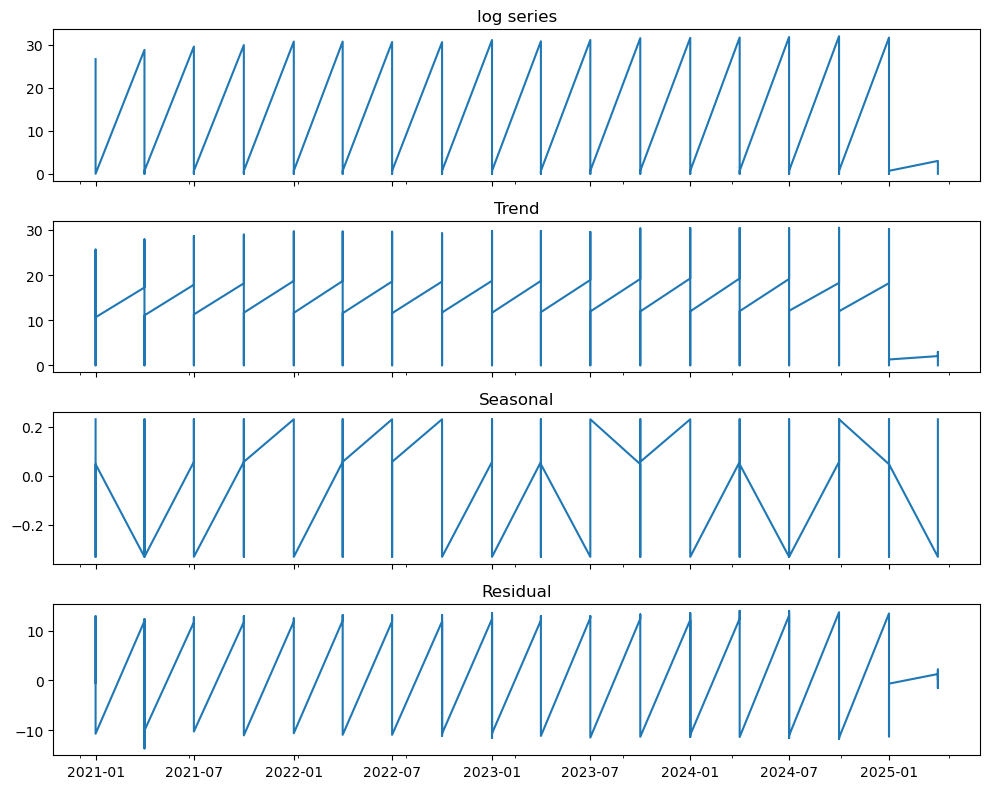

ADF on log: p = 0.0000
ADF on 1st‐diff: p = 0.0000
ADF on (1st‐diff, 4‐lag diff): p = 0.0000
KPSS on diff_seasonal: p = 0.1000  (want > 0.05)


/var/folders/v1/v83gn92x7vv8phs46b_nj2gr0000gn/T/ipykernel_26995/3712897923.py:41: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3793
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 4)   Log Likelihood              -12698.225
Date:                           Wed, 14 May 2025   AIC                          25408.450
Time:                                   16:46:18   BIC                          25445.887
Sample:                                        0   HQIC                         25421.757
                                          - 3793                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1405      0.019     -7.308      0.000      -0.178      -0.103
ar.L2         -0.0724      0.017     -4.207

In [ ]:
row = grouped_rows[0]
pdf = pd.DataFrame([(r['parsed_date'], r['OBS_VALUE']) for r in row['time_series']],
                   columns=['date','value']).set_index('date')['value'].astype(float)
model = check_stationarity_and_fit(pdf, m=4, do_log=True)

In [ ]:
row = grouped_rows[0]
row

Row(SEC_TYPE_CFI='[RF] Mini-future certificates', FREQ='[Q] quarterly', time_series=[Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=388949246000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=21406828500.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=31330584600.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=121671516000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=340123025000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=866999.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=11749896.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=4177248.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=31330584600.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=9444362200.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=40392663000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=39978156000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=16100256800.0), Row(parsed_date=datetime.dat

25/05/14 19:19:57 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 319604 ms exceeds timeout 120000 ms
25/05/14 19:19:57 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/14 19:19:58 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

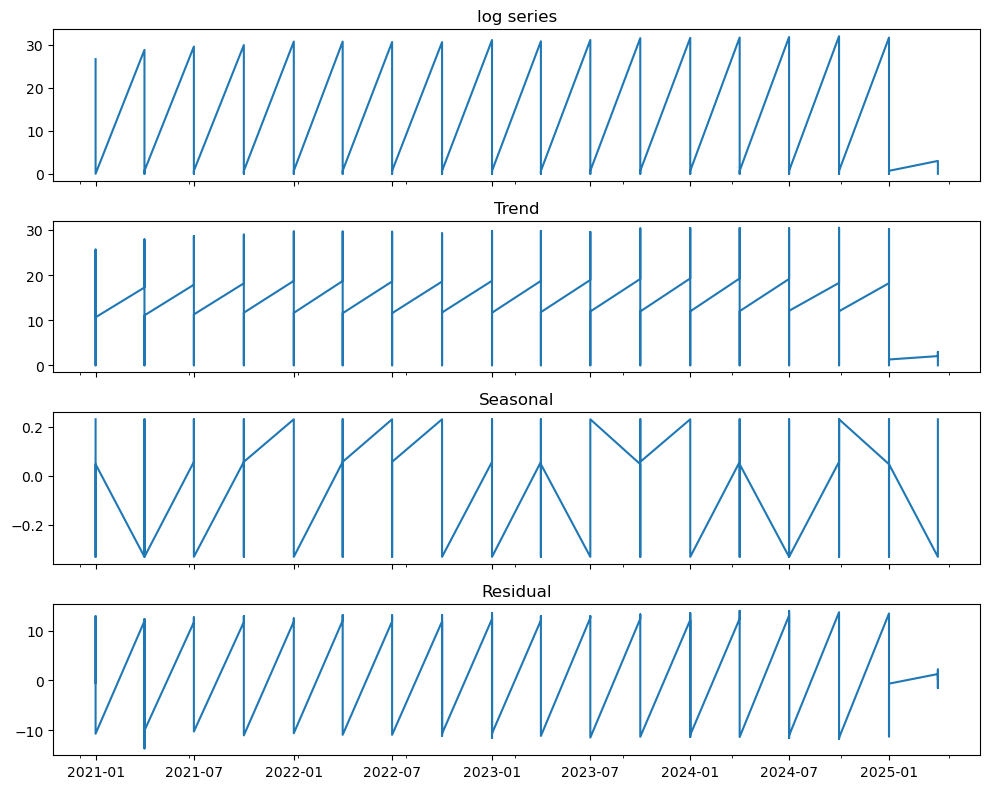

ADF on log: p = 0.0000
ADF on 1st‐diff: p = 0.0000
ADF on (1st‐diff, 4‐lag diff): p = 0.0000
KPSS on diff_seasonal: p = 0.1000  (want > 0.05)


/var/folders/v1/v83gn92x7vv8phs46b_nj2gr0000gn/T/ipykernel_26995/3712897923.py:41: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3793
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 4)   Log Likelihood              -12698.225
Date:                           Wed, 14 May 2025   AIC                          25408.450
Time:                                   19:02:27   BIC                          25445.887
Sample:                                        0   HQIC                         25421.757
                                          - 3793                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1405      0.019     -7.308      0.000      -0.178      -0.103
ar.L2         -0.0724      0.017     -4.207

date         value  value_log   forecast   residual  \
date                                                                    
2021-01-01  2021-01-01  3.889492e+11  26.686715   0.000000  26.686715   
2021-01-01  2021-01-01  2.140683e+10  23.786976  26.686594  -2.899618   
2021-01-01  2021-01-01  3.133058e+10  24.167861  23.786977   0.380883   
2021-01-01  2021-01-01  1.216715e+11  25.524591  24.167906   1.356685   
2021-01-01  2021-01-01  3.401230e+11  26.552573  38.867941 -12.315368   

            is_outlier  
date                    
2021-01-01       False  
2021-01-01       False  
2021-01-01       False  
2021-01-01       False  
2021-01-01       False

In [ ]:
import numpy as np
import pandas as pd
row = grouped_rows[0]
pdf = pd.DataFrame([(r['parsed_date'], r['OBS_VALUE']) for r in row['time_series']],
                   columns=['date','value']).set_index('date')['value'].astype(float)

do_log = (pdf > 0).all()
ts = np.log(pdf) if do_log else pdf.copy()
model = check_stationarity_and_fit(pdf, m=4, do_log=True)
fitted_vals = model.predict_in_sample()
residuals = ts - fitted_vals
threshold = 4 * residuals.std()
is_outlier = residuals.abs() > threshold

df_res = pd.DataFrame({
    'date':       ts.index,
    'value':      pdf.values,
    'value_log':  ts.values,
    'forecast':   fitted_vals,
    'residual':   residuals,
    'is_outlier': is_outlier
})
df_res.head()

In [ ]:
model

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 4),
      suppress_warnings=True, with_intercept=False)

In [ ]:
df =df_res

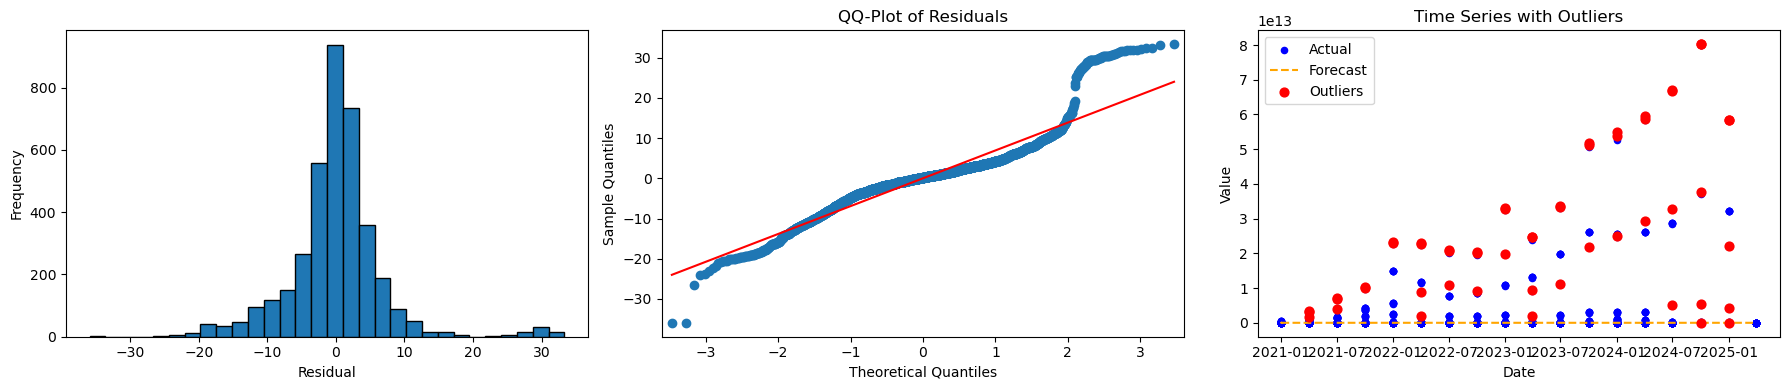

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot


residuals = df['residual']

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].hist(residuals, bins=30, edgecolor='black')

axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Frequency")


qqplot(residuals, line='s', ax=axes[1])
axes[1].set_title("QQ-Plot of Residuals")

axes[2].scatter(df['date'], df['value'], color='blue', s=20, label='Actual')
axes[2].plot(df['date'], df['forecast'], linestyle='--', color='orange', label='Forecast')
axes[2].scatter(
    df[df['is_outlier']]['date'],
    df[df['is_outlier']]['value'],
    color='red', s=40, label='Outliers', zorder=5
)
axes[2].set_title("Time Series with Outliers")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Value")
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
### kjo nuk me pelqen se ka heavy tails dhe s esht e thjesht q ti besh predict

In [ ]:
def check_and_flag(ts_raw, m=4, do_log=True):


    ts = np.log(ts_raw) if do_log and (ts_raw > 0).all() else ts_raw.copy()
    label = "log" if do_log else "raw"

    # Plot & decompose
    fig, ax = plt.subplots(4,1, figsize=(10,8), sharex=True)
    ts.plot(ax=ax[0], title=f"{label} series")
    res = seasonal_decompose(ts, model='additive', period=m)
    ax[1].plot(res.trend);    ax[1].set_title("Trend")
    ax[2].plot(res.seasonal); ax[2].set_title("Seasonal")
    ax[3].plot(res.resid);    ax[3].set_title("Residual")
    plt.tight_layout(); plt.show()

    # ADF on raw/log series
    p_raw = adfuller(ts.dropna())[1]
    print(f"ADF on {label}: p = {p_raw:.4f}")

    # First difference
    diff1 = ts.diff().dropna()
    p_diff1 = adfuller(diff1)[1]
    print(f"ADF on 1st‐diff: p = {p_diff1:.4f}")

    # Seasonal difference
    diff_seasonal = diff1.diff(m).dropna()
    p_seas = adfuller(diff_seasonal)[1]
    print(f"ADF on (1st‐diff, {m}‐lag diff): p = {p_seas:.4f}")

    # KPSS as a cross-check (stationarity vs. trend stationarity)
    kpss_p = kpss(diff_seasonal, nlags="auto")[1]
    print(f"KPSS on diff_seasonal: p = {kpss_p:.4f}  (want > 0.05)")

    ts = np.log(ts_raw) if do_log and (ts_raw>0).all() else ts_raw.copy()
    ts.name = 'value_log' if do_log else 'value'


    model = auto_arima(
        ts, start_p=0, max_p=3,
        start_q=0, max_q=3,
        d=1, D=1,
        seasonal=True, m=m,
        stepwise=True, suppress_warnings=True
    )

    fitted, ci = model.predict_in_sample(return_conf_int=True, alpha=0.01)
    lower, upper = ci[:,0], ci[:,1]
    outliers = (ts < lower) | (ts > upper)


    df_res = pd.DataFrame({
        'date'       : ts.index,
        'value'      : np.exp(ts) if do_log else ts.values,
        'forecast'   : fitted,
        'lower_ci'   : lower,
        'upper_ci'   : upper,
        'residual'   : ts - fitted,
        'is_outlier' : outliers
    })
    if do_log:
        df_res['value_log'] = ts.values

    return df_res, model

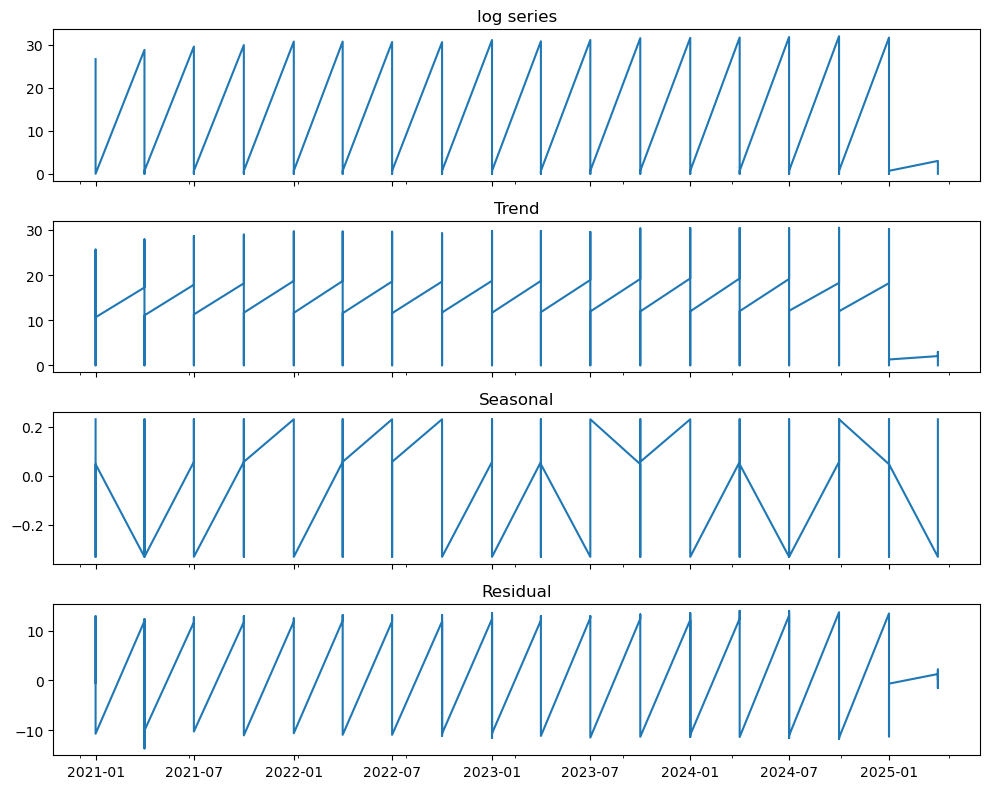

ADF on log: p = 0.0000
ADF on 1st‐diff: p = 0.0000
ADF on (1st‐diff, 4‐lag diff): p = 0.0000
KPSS on diff_seasonal: p = 0.1000  (want > 0.05)


/var/folders/v1/v83gn92x7vv8phs46b_nj2gr0000gn/T/ipykernel_26995/614846663.py:31: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [ ]:
row = grouped_rows[0]
pdf = pd.DataFrame([(r['parsed_date'], r['OBS_VALUE']) for r in row['time_series']],
                   columns=['date','value']).set_index('date')['value'].astype(float)
df_res, model = check_and_flag(pdf, m=4, do_log=True)

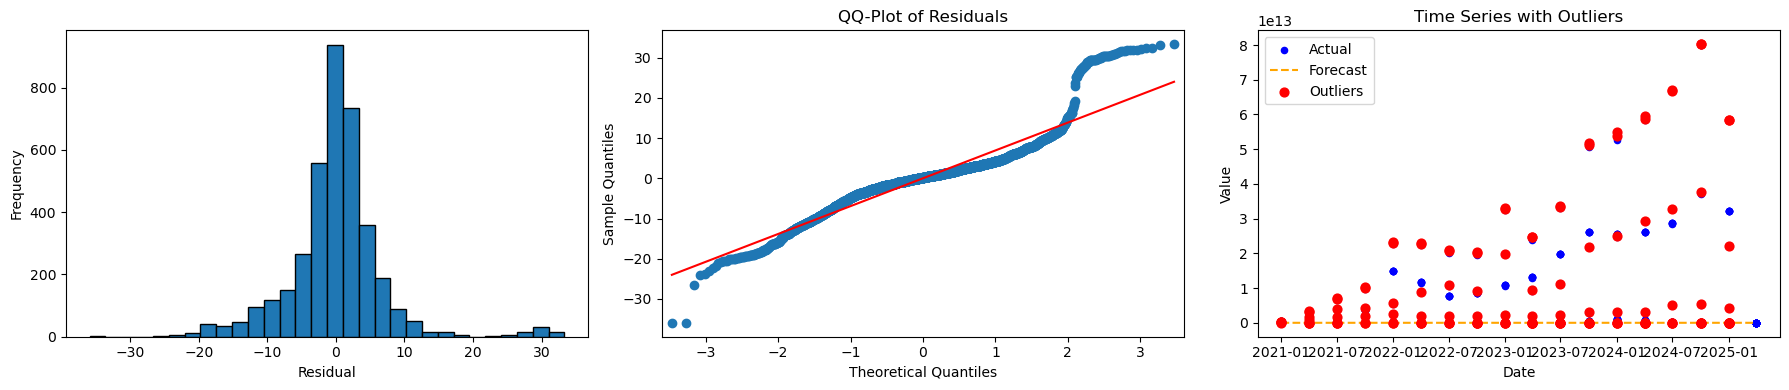

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

df = df_res
residuals = df['residual']

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].hist(residuals, bins=30, edgecolor='black')

axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Frequency")


qqplot(residuals, line='s', ax=axes[1])
axes[1].set_title("QQ-Plot of Residuals")

axes[2].scatter(df['date'], df['value'], color='blue', s=20, label='Actual')
axes[2].plot(df['date'], df['forecast'], linestyle='--', color='orange', label='Forecast')
axes[2].scatter(
    df[df['is_outlier']]['date'],
    df[df['is_outlier']]['value'],
    color='red', s=40, label='Outliers', zorder=5
)
axes[2].set_title("Time Series with Outliers")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Value")
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
###perdor me shume segregime sepse do bej me shume sens. do ta shofi nqs ky debti q esht quajt si outlier esht meverte outlier apo jo ne shtetin e vet.
# dhe pastaj beje plotin per gjith shtetet

In [57]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, kpss
from joblib import Parallel, delayed

def check_stationarity_and_fit(ts_raw, m=4, do_log=True):
    ts = np.log(ts_raw) if do_log and (ts_raw > 0).all() else ts_raw.copy()

    model = auto_arima(
        ts, start_p=0, max_p=3, start_q=0, max_q=3,
        d=1, D=1, seasonal=True, m=m,
        stepwise=True, suppress_warnings=True
    )
    return model, ts

def detect_outliers_in_group(df_group, seasonal_period=4, log_thresh=0.05, std_thresh=4):
    ts_raw = df_group.set_index('parsed_date')['OBS_VALUE'].astype(float).sort_index()
    if len(ts_raw) < 12:
        return None  # too short for seasonal modeling

    try:
        model, ts = check_stationarity_and_fit(ts_raw, m=seasonal_period, do_log=True)
        fitted_vals = model.predict_in_sample()
        residuals = ts - fitted_vals
        abs_res = residuals.abs()

        # Apply statistical and practical threshold
        threshold = std_thresh * residuals.std()
        is_outlier = (abs_res > threshold) & (abs_res > log_thresh * ts_raw)

        return pd.DataFrame({
            'issuer_cou': df_group['ISSUER_COU'].iloc[0],
            'sec_type_cfi': df_group['SEC_TYPE_CFI'].iloc[0],
            'date': ts.index,
            'value': ts_raw.values,
            'value_log': ts.values,
            'forecast': fitted_vals,
            'residual': residuals,
            'is_outlier': is_outlier
        })

    except Exception as e:
        print(f"[ERROR] {df_group['ISSUER_COU'].iloc[0]} - {df_group['SEC_TYPE_CFI'].iloc[0]}: {e}")
        return None

In [58]:
from tqdm import tqdm

results = []
grouped = df_all.groupby(['ISSUER_COU', 'SEC_TYPE_CFI'])

for (key, group) in tqdm(grouped, total=grouped.ngroups, desc="Processing groups"):
    result_df = detect_outliers_in_group(group)
    if result_df is not None:
        results.append(result_df)

df_all_outliers = pd.concat(results, ignore_index=True)

Processing groups:   6%|▌         | 49/876 [07:51<3:28:14, 15.11s/it]/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

Processing groups:   6%|▋         | 55/876 [07:53<59:08,  4.32s/it]  /opt/anaconda3/envs/datasci/lib/python3.12/site-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

Processing groups:  16%|█▌        | 137/876 [09:49<04:07,  2.98it/s]/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-seri

In [59]:
df_all_outliers

issuer_cou              sec_type_cfi        date         value  \
0               Z                         Z  2021-01-01  1.310005e+09   
1               Z                         Z  2021-01-01  2.900000e+01   
2               Z                         Z  2021-01-01  1.000000e+00   
3               Z                         Z  2021-01-01  1.193761e+06   
4               Z                         Z  2021-01-01  1.000000e+00   
...           ...                       ...         ...           ...   
150778  [V5] EU27  [ZNAV] CFI not available  2025-01-01  9.000000e+00   
150779  [V5] EU27  [ZNAV] CFI not available  2025-01-01  1.000000e+00   
150780  [V5] EU27  [ZNAV] CFI not available  2025-01-01  1.500000e+01   
150781  [V5] EU27  [ZNAV] CFI not available  2025-01-01  1.500000e+01   
150782  [V5] EU27  [ZNAV] CFI not available  2025-01-01  1.500000e+01   

           value_log      forecast      residual  is_outlier  
0       1.310005e+09  0.000000e+00  1.310005e+09       False  
1       2.900000e+01  6.000450e+08 -6.000449e+08       False  
2       1.000000e+00  4.648845e+08 -4.648845e+08       False  
3       1.193761e+06  5.914874e+08 -5.902937e+08       False  
4       1.000000e+00  9.407045e+08 -9.407045e+08       False  
...              ...           ...           ...         ...  
150778  2.197225e+00 -6.694992e-02  2.264174e+00       False  
150779  0.000000e+00  8.138793e-01 -8.138793e-01       False  
150780  2.708050e+00  2.881598e+00 -1.735481e-01       False  
150781  2.708050e+00  1.343375e+00  1.364675e+00       False  
150782  2.708050e+00  1.419223e+00  1.288827e+00       False  

[150783 rows x 8 columns]

In [81]:
k = df_all_outliers.drop(['is_outlier','residual','forecast','value_log'],axis=1)
k

issuer_cou              sec_type_cfi        date         value
0               Z                         Z  2021-01-01  1.310005e+09
1               Z                         Z  2021-01-01  2.900000e+01
2               Z                         Z  2021-01-01  1.000000e+00
3               Z                         Z  2021-01-01  1.193761e+06
4               Z                         Z  2021-01-01  1.000000e+00
...           ...                       ...         ...           ...
150778  [V5] EU27  [ZNAV] CFI not available  2025-01-01  9.000000e+00
150779  [V5] EU27  [ZNAV] CFI not available  2025-01-01  1.000000e+00
150780  [V5] EU27  [ZNAV] CFI not available  2025-01-01  1.500000e+01
150781  [V5] EU27  [ZNAV] CFI not available  2025-01-01  1.500000e+01
150782  [V5] EU27  [ZNAV] CFI not available  2025-01-01  1.500000e+01

[150783 rows x 4 columns]

In [83]:
k['sec_type_cfi'].value_counts()

sec_type_cfi
Z                                                 30992
[ZALL] All records if applicable                  12326
[SCRT] Securities                                 12291
[D] Debt                                          11207
[DB] Bonds                                         9587
[E] Equity                                         8385
[ES] Shares                                        6545
[DT] MTN                                           6280
[R] Entitlement (rights)                           5184
[DE] Structured debt (no capital protection)       4835
[RW] Warrants                                      4494
[EY] Structured instruments (participation)        4300
[DS] Structured debt (capital protection)          3901
[RF] Mini-future certificates                      3763
[DA] ABS                                           3729
[DM] Other debt                                    2772
[DY] MMI                                           2749
[DG] MBS                           

In [86]:
debt = k[k['sec_type_cfi']=="[D] Debt"]
debt

issuer_cou sec_type_cfi        date        value
22169           Z     [D] Debt  2021-01-01  164675200.0
22170           Z     [D] Debt  2021-01-01         11.0
22171           Z     [D] Debt  2021-01-01          2.0
22172           Z     [D] Debt  2021-01-01         38.0
22173           Z     [D] Debt  2021-01-01         79.0
...           ...          ...         ...          ...
147319  [V5] EU27     [D] Debt  2025-04-01          2.0
147320  [V5] EU27     [D] Debt  2025-04-01          2.0
147321  [V5] EU27     [D] Debt  2025-04-01          2.0
147322  [V5] EU27     [D] Debt  2025-04-01          2.0
147323  [V5] EU27     [D] Debt  2025-04-01          2.0

[11207 rows x 4 columns]

In [91]:
nl_debt = debt[debt['issuer_cou']=='[NL] Netherlands']
nl_debt

issuer_cou sec_type_cfi        date  value
121796  [NL] Netherlands     [D] Debt  2021-01-01    1.0
121797  [NL] Netherlands     [D] Debt  2021-01-01    1.0
121798  [NL] Netherlands     [D] Debt  2021-01-01   36.0
121799  [NL] Netherlands     [D] Debt  2021-01-01   37.0
121800  [NL] Netherlands     [D] Debt  2021-01-01   11.0
...                  ...          ...         ...    ...
121966  [NL] Netherlands     [D] Debt  2025-04-01    1.0
121967  [NL] Netherlands     [D] Debt  2025-04-01    1.0
121968  [NL] Netherlands     [D] Debt  2025-04-01    1.0
121969  [NL] Netherlands     [D] Debt  2025-04-01    1.0
121970  [NL] Netherlands     [D] Debt  2025-04-01    1.0

[175 rows x 4 columns]

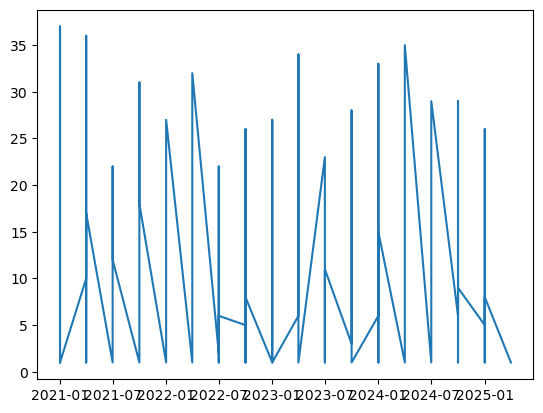

In [90]:
plt.plot(nl_debt['date'],nl_debt['value'])

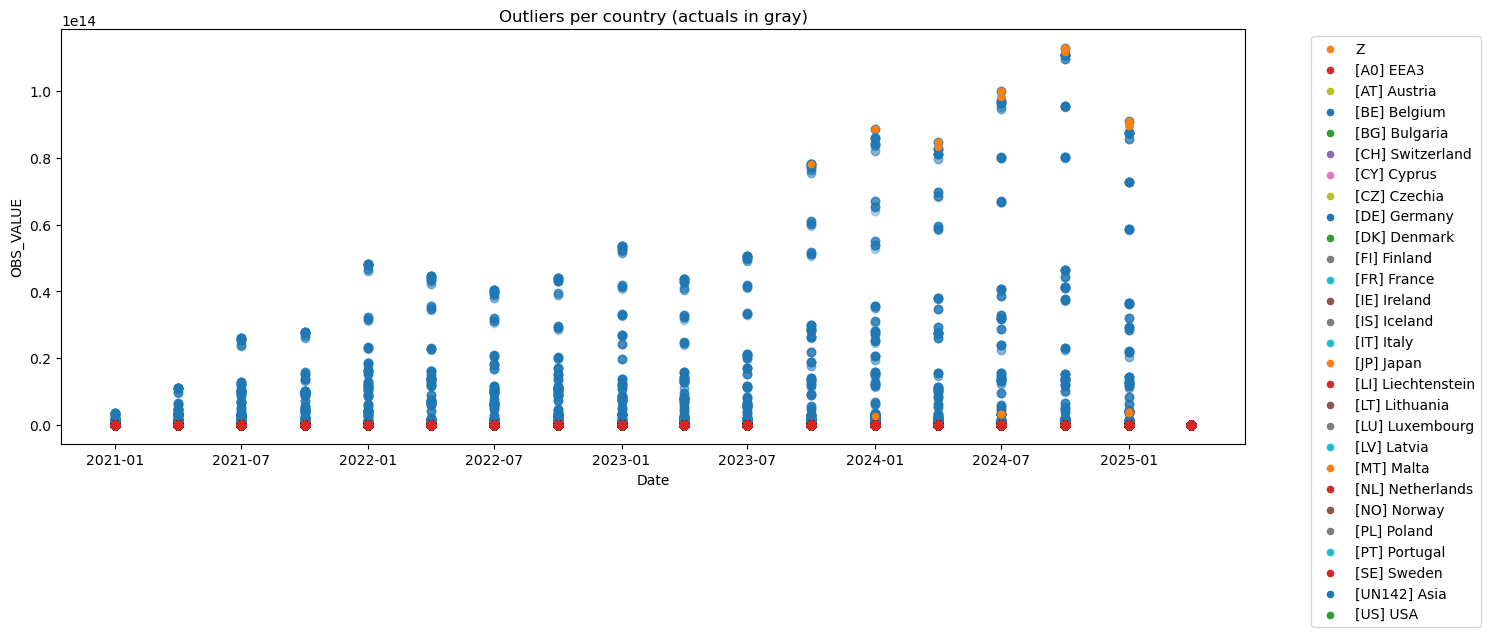

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
countries = df_all_outliers['issuer_cou'].unique()

for country in countries:
    sub = df_all_outliers[df_all_outliers['issuer_cou'] == country]

    # Actuals in light gray
    plt.scatter(sub['date'], sub['value'], alpha=0.3, label=None)

    # Outliers in red
    out = sub[sub['is_outlier']]
    if not out.empty:
        plt.scatter(out['date'], out['value'], s=20, label=country)

plt.title("Outliers per country (actuals in gray)")
plt.xlabel("Date")
plt.ylabel("OBS_VALUE")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [78]:
row = grouped_rows[0]
row

Row(SEC_TYPE_CFI='Z', ISSUER_COU='Z', time_series=[Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1310004990.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1130444670.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=100446208000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=489361375000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=2097586300.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=677652860.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=38.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=61.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1149.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=12.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=14.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1335284.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=2711631950000.0), Row(parsed_date=datetime.date(2021, 1, 1), OBS_VALUE=1036725760.0), Row(parsed_date=datetime.date(20

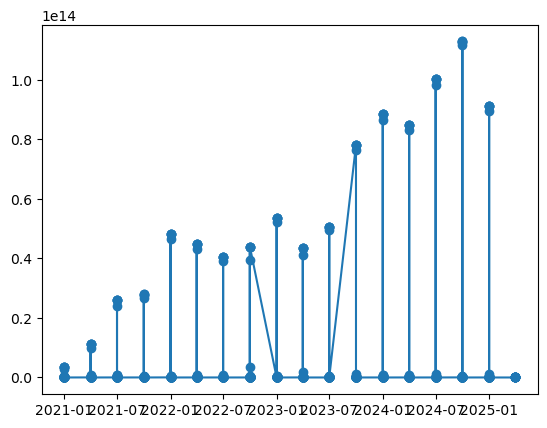

In [70]:
ts_data = row['time_series']
group_key = f"{row['SEC_TYPE_CFI']}"

pdf = pd.DataFrame([(r['parsed_date'], r['OBS_VALUE']) for r in ts_data],
                       columns=['date', 'value']).sort_values('date')
plt.plot(pdf['date'], pdf['value'], marker='o')

In [3]:
a = df_joined.toPandas()
a

25/05/15 13:46:35 WARN TaskSetManager: Stage 6 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


KEY  \
0              PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.C.Z.Z.Z.Z.Z.Z.Z.Z   
1              PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.C.Z.Z.Z.Z.Z.Z.Z.Z   
2              PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.C.Z.Z.Z.Z.Z.Z.Z.Z   
3              PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.C.Z.Z.Z.Z.Z.Z.Z.Z   
4              PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.C.Z.Z.Z.Z.Z.Z.Z.Z   
...                                                   ...   
152023  PROSP3.NUM_PRSP.Q.V5.ZNAV.Z.Z.Z.Z.Z.A6.Z.Z.Z.Z...   
152024  PROSP3.NUM_PRSP.Q.V5.ZNAV.Z.Z.Z.Z.Z.A6.Z.Z.Z.Z...   
152025  PROSP3.NUM_PRSP.Q.V5.ZNAV.Z.Z.Z.Z.Z.A6.Z.Z.Z.Z...   
152026  PROSP3.NUM_PRSP.Q.V5.ZNAV.Z.Z.Z.Z.Z.DK.Z.Z.Z.Z...   
152027  PROSP3.NUM_PRSP.Q.V5.ZNAV.Z.Z.Z.Z.Z.IT.Z.Z.Z.Z...   

                                                    TITLE  TITLE_COMPL  \
0       Quarterly consideration offered of filed CIIs ...          NaN   
1       Quarterly consideration offered of filed CIIs ...          NaN   
2       Quarterly consideration offered of filed CIIs ...          NaN   
3       Quarterly consideration offered of filed CIIs ...          NaN   
4       Quarterly consideration offered of filed CIIs ...          NaN   
...                                                   ...          ...   
152023  Quarterly number of prospectuses on instrument...          NaN   
152024  Quarterly number of prospectuses on instrument...          NaN   
152025  Quarterly number of prospectuses on instrument...          NaN   
152026  Quarterly number of prospectuses on instrument...          NaN   
152027  Quarterly number of prospectuses on instrument...          NaN   

                           PROSP3_MEASURE           FREQ      S_NCA  \
0         [MV] Consideration offer in EUR  [Q] quarterly  [A0] EEA3   
1         [MV] Consideration offer in EUR  [Q] quarterly  [A0] EEA3   
2         [MV] Consideration offer in EUR  [Q] quarterly  [A0] EEA3   
3         [MV] Consideration offer in EUR  [Q] quarterly  [A0] EEA3   
4         [MV] Consideration offer in EUR  [Q] quarterly  [A0] EEA3   
...                                   ...            ...        ...   
152023  [NUM_PRSP] Number of prospectuses  [Q] quarterly  [V5] EU27   
152024  [NUM_PRSP] Number of prospectuses  [Q] quarterly  [V5] EU27   
152025  [NUM_PRSP] Number of prospectuses  [Q] quarterly  [V5] EU27   
152026  [NUM_PRSP] Number of prospectuses  [Q] quarterly  [V5] EU27   
152027  [NUM_PRSP] Number of prospectuses  [Q] quarterly  [V5] EU27   

                      PROSP3_SECURITIES_TYPE MTR CURR_ISSNC PROSP3_OFFER_TYPE  \
0                                          Z   Z          Z                 Z   
1                                          Z   Z          Z                 Z   
2                                          Z   Z          Z                 Z   
3                                          Z   Z          Z                 Z   
4                                          Z   Z          Z                 Z   
...                                      ...  ..        ...               ...   
152023  [ZNAV] Securities type not available   Z          Z                 Z   
152024  [ZNAV] Securities type not available   Z          Z                 Z   
152025  [ZNAV] Securities type not available   Z          Z                 Z   
152026  [ZNAV] Securities type not available   Z          Z                 Z   
152027  [ZNAV] Securities type not available   Z          Z                 Z   

        ... PROSP3_PRSP_TYPE PROSP3_SME_CAT_TYPE PROSP3_PSSP PROSP3_VENUE  \
0       ...                Z                   Z           Z            Z   
1       ...                Z                   Z           Z            Z   
2       ...                Z                   Z           Z            Z   
3       ...                Z                   Z           Z            Z   
4       ...                Z                   Z           Z            Z   
...     ...              ...                 ...         ...          ...   
152023  ...                Z                   Z           Z       

In [6]:
debt = a[a['SEC_TYPE_CFI']=="[D] Debt"]
debt

KEY  \
7              PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
8              PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
9              PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
10             PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
11             PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
...                                                   ...   
148195  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.D.V5.Z.Z.Z.Z....   
148196  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.D.V5.Z.Z.Z.Z....   
148197  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.D.V5.Z.Z.Z.Z....   
148198  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.D.V5.Z.Z.Z.Z....   
148199  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.D.V5.Z.Z.Z.Z....   

                                                    TITLE  TITLE_COMPL  \
7       Quarterly consideration offered of filed Debt ...          NaN   
8       Quarterly consideration offered of filed Debt ...          NaN   
9       Quarterly consideration offered of filed Debt ...          NaN   
10      Quarterly consideration offered of filed Debt ...          NaN   
11      Quarterly consideration offered of filed Debt ...          NaN   
...                                                   ...          ...   
148195  Quarterly number of issuers of Debt from EU27 ...          NaN   
148196  Quarterly number of issuers of Debt from EU27 ...          NaN   
148197  Quarterly number of issuers of Debt from EU27 ...          NaN   
148198  Quarterly number of issuers of Debt from EU27 ...          NaN   
148199  Quarterly number of issuers of Debt from EU27 ...          NaN   

                                           PROSP3_MEASURE           FREQ  \
7                         [MV] Consideration offer in EUR  [Q] quarterly   
8                         [MV] Consideration offer in EUR  [Q] quarterly   
9                         [MV] Consideration offer in EUR  [Q] quarterly   
10                        [MV] Consideration offer in EUR  [Q] quarterly   
11                        [MV] Consideration offer in EUR  [Q] quarterly   
...                                                   ...            ...   
148195  [NUM_ISSUER] Number of unique issuers in secur...  [Q] quarterly   
148196  [NUM_ISSUER] Number of unique issuers in secur...  [Q] quarterly   
148197  [NUM_ISSUER] Number of unique issuers in secur...  [Q] quarterly   
148198  [NUM_ISSUER] Number of unique issuers in secur...  [Q] quarterly   
148199  [NUM_ISSUER] Number of unique issuers in secur...  [Q] quarterly   

            S_NCA PROSP3_SECURITIES_TYPE MTR CURR_ISSNC PROSP3_OFFER_TYPE  \
7       [A0] EEA3                      Z   Z          Z                 Z   
8       [A0] EEA3                      Z   Z          Z                 Z   
9       [A0] EEA3                      Z   Z          Z                 Z   
10      [A0] EEA3                      Z   Z          Z                 Z   
11      [A0] EEA3                      Z   Z          Z                 Z   
...           ...                    ...  ..        ...               ...   
148195  [V5] EU27                      Z   Z          Z                 Z   
148196  [V5] EU27                      Z   Z          Z                 Z   
148197  [V5] EU27                      Z   Z          Z                 Z   
148198  [V5] EU27                      Z   Z          Z                 Z   
148199  [V5] EU27                      Z   Z          Z                 Z   

        ... PROSP3_PRSP_TYPE PROSP3_SME_CAT_TYPE PROSP3_PSSP PROSP3_VENUE  \
7       ...                Z                   Z           Z            Z   
8       ...                Z                   Z           Z            Z   
9       ...                Z                   Z           Z            Z   
10      ...                Z                   Z           Z            Z   
11      ...                Z                   Z           Z            Z   
...     ...              ...                 ...         ...          ...   
148195  ...                Z                   Z       

In [7]:
nl_debt = debt[debt['S_NCA']=='[NL] Netherlands']
nl_debt

KEY  \
6639    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
6640    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
6641    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
6642    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
6643    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
...                                                   ...   
140114  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   
140115  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   
140116  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   
140117  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   
140118  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   

                                                    TITLE  TITLE_COMPL  \
6639        Quarterly number of filed Debt in Netherlands          NaN   
6640        Quarterly number of filed Debt in Netherlands          NaN   
6641        Quarterly number of filed Debt in Netherlands          NaN   
6642        Quarterly number of filed Debt in Netherlands          NaN   
6643        Quarterly number of filed Debt in Netherlands          NaN   
...                                                   ...          ...   
140114  Quarterly number of filed Debt in Netherlands ...          NaN   
140115  Quarterly number of filed Debt in Netherlands ...          NaN   
140116  Quarterly number of filed Debt in Netherlands ...          NaN   
140117  Quarterly number of filed Debt in Netherlands ...          NaN   
140118  Quarterly number of filed Debt in Netherlands ...          NaN   

                           PROSP3_MEASURE           FREQ             S_NCA  \
6639    [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   
6640    [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   
6641    [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   
6642    [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   
6643    [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   
...                                   ...            ...               ...   
140114  [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   
140115  [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   
140116  [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   
140117  [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   
140118  [NUM_INSTR] Number of instruments  [Q] quarterly  [NL] Netherlands   

       PROSP3_SECURITIES_TYPE MTR CURR_ISSNC PROSP3_OFFER_TYPE  ...  \
6639                        Z   Z          Z                 Z  ...   
6640                        Z   Z          Z                 Z  ...   
6641                        Z   Z          Z                 Z  ...   
6642                        Z   Z          Z                 Z  ...   
6643                        Z   Z          Z                 Z  ...   
...                       ...  ..        ...               ...  ...   
140114                      Z   Z          Z                 Z  ...   
140115                      Z   Z          Z                 Z  ...   
140116                      Z   Z          Z                 Z  ...   
140117                      Z   Z          Z                 Z  ...   
140118                      Z   Z          Z                 Z  ...   

       PROSP3_PRSP_TYPE PROSP3_SME_CAT_TYPE PROSP3_PSSP PROSP3_VENUE  \
6639                  Z                   Z           Z            Z   
6640                  Z                   Z           Z            Z   
6641                  Z                   Z           Z            Z   
6642                  Z                   Z           Z            Z   
6643                  Z                   Z           Z            Z   
...                 ...                 ...         ...          ...   
140114                Z                   Z           Z            Z   
140115                Z                   Z           Z           

In [8]:
df = nl_debt

In [9]:
df.groupby(['TITLE', 'TIME_PERIOD']).size().reset_index(name='count').query('count > 1')

TITLE TIME_PERIOD  count
22   Quarterly consideration offered of filed Debt ...     2022-Q2      2
25   Quarterly consideration offered of filed Debt ...     2023-Q1      2
26   Quarterly consideration offered of filed Debt ...     2023-Q2      2
29   Quarterly consideration offered of filed Debt ...     2024-Q1      2
31   Quarterly consideration offered of filed Debt ...     2024-Q3      2
96   Quarterly number of filed Debt in Netherlands ...     2021-Q1      2
98   Quarterly number of filed Debt in Netherlands ...     2021-Q3      2
100  Quarterly number of filed Debt in Netherlands ...     2022-Q1      2
101  Quarterly number of filed Debt in Netherlands ...     2022-Q2      2
102  Quarterly number of filed Debt in Netherlands ...     2022-Q3      2
104  Quarterly number of filed Debt in Netherlands ...     2023-Q1      2
105  Quarterly number of filed Debt in Netherlands ...     2023-Q2      2
107  Quarterly number of filed Debt in Netherlands ...     2023-Q4      2
108  Quarterly number of filed Debt in Netherlands ...     2024-Q1      2
109  Quarterly number of filed Debt in Netherlands ...     2024-Q2      2
110  Quarterly number of filed Debt in Netherlands ...     2024-Q3      2
111  Quarterly number of filed Debt in Netherlands ...     2024-Q4      2
112  Quarterly number of filed Debt in Netherlands ...     2025-Q1      2

In [ ]:
sample = df[(df['TITLE'].str.startswith('Quarterly number of filed Debt in Netherlands')) &
            (df['TIME_PERIOD'] == '2023-Q1')]

sample = sample.reset_index(drop=True)
all_equal_except_obs = sample.drop(columns=['OBS_VALUE']).nunique().max() == 1
print("All other columns identical:", all_equal_except_obs)
print("OBS_VALUEs:", sample['OBS_VALUE'].tolist())

All other columns identical: False
OBS_VALUEs: [725.0, 720.0, 724.0, 3.0, 1.0, 1.0]


In [ ]:
conflicting = df.groupby(['TITLE', 'TIME_PERIOD']).filter(lambda x: len(x) > 1)

In [13]:
sample = conflicting[(conflicting['TITLE'] == 'Quarterly number of filed Debt in Netherlands') &
                     (conflicting['TIME_PERIOD'] == '2023-Q1')]
diff_cols = sample.loc[:, sample.nunique(dropna=False) > 1].columns.tolist()
print("Columns that differ:", diff_cols)
sample[diff_cols]

Columns that differ: []


Empty DataFrame
Columns: []
Index: []

In [15]:
conflicting_rows = df.groupby(['TITLE', 'TIME_PERIOD']).filter(lambda x: len(x) > 1)
from collections import defaultdict

diff_report = defaultdict(list)
for (title, time), group in conflicting_rows.groupby(['TITLE', 'TIME_PERIOD']):
    varying_cols = group.loc[:, group.nunique(dropna=False) > 1].columns.tolist()
    diff_report[(title, time)] = varying_cols

diff_df = pd.DataFrame([
    {'TITLE': k[0], 'TIME_PERIOD': k[1], 'DIFFERING_COLUMNS': v}
    for k, v in diff_report.items()
])

diff_df

TITLE TIME_PERIOD  \
0   Quarterly consideration offered of filed Debt ...     2022-Q2   
1   Quarterly consideration offered of filed Debt ...     2023-Q1   
2   Quarterly consideration offered of filed Debt ...     2023-Q2   
3   Quarterly consideration offered of filed Debt ...     2024-Q1   
4   Quarterly consideration offered of filed Debt ...     2024-Q3   
5   Quarterly number of filed Debt in Netherlands ...     2021-Q1   
6   Quarterly number of filed Debt in Netherlands ...     2021-Q3   
7   Quarterly number of filed Debt in Netherlands ...     2022-Q1   
8   Quarterly number of filed Debt in Netherlands ...     2022-Q2   
9   Quarterly number of filed Debt in Netherlands ...     2022-Q3   
10  Quarterly number of filed Debt in Netherlands ...     2023-Q1   
11  Quarterly number of filed Debt in Netherlands ...     2023-Q2   
12  Quarterly number of filed Debt in Netherlands ...     2023-Q4   
13  Quarterly number of filed Debt in Netherlands ...     2024-Q1   
14  Quarterly number of filed Debt in Netherlands ...     2024-Q2   
15  Quarterly number of filed Debt in Netherlands ...     2024-Q3   
16  Quarterly number of filed Debt in Netherlands ...     2024-Q4   
17  Quarterly number of filed Debt in Netherlands ...     2025-Q1   

                      DIFFERING_COLUMNS  
0       [KEY, ISSUER_SECTOR, OBS_VALUE]  
1       [KEY, ISSUER_SECTOR, OBS_VALUE]  
2   [KEY, ISSUER_SECTOR, PK, OBS_VALUE]  
3       [KEY, ISSUER_SECTOR, OBS_VALUE]  
4       [KEY, ISSUER_SECTOR, OBS_VALUE]  
5       [KEY, ISSUER_SECTOR, OBS_VALUE]  
6       [KEY, ISSUER_SECTOR, OBS_VALUE]  
7       [KEY, ISSUER_SECTOR, OBS_VALUE]  
8       [KEY, ISSUER_SECTOR, OBS_VALUE]  
9       [KEY, ISSUER_SECTOR, OBS_VALUE]  
10      [KEY, ISSUER_SECTOR, OBS_VALUE]  
11      [KEY, ISSUER_SECTOR, OBS_VALUE]  
12      [KEY, ISSUER_SECTOR, OBS_VALUE]  
13  [KEY, ISSUER_SECTOR, PK, OBS_VALUE]  
14      [KEY, ISSUER_SECTOR, OBS_VALUE]  
15      [KEY, ISSUER_SECTOR, OBS_VALUE]  
16  [KEY, ISSUER_SECTOR, PK, OBS_VALUE]  
17      [KEY, ISSUER_SECTOR, OBS_VALUE]

In [ ]:
detailed_diffs = []

for _, row in diff_df.iterrows():
    title = row['TITLE']
    time_period = row['TIME_PERIOD']
    diff_cols = row['DIFFERING_COLUMNS']
    group = df[(df['TITLE'] == title) & (df['TIME_PERIOD'] == time_period)]
    if group.empty:
        continue

    subset = group[diff_cols].copy()
    subset['TITLE'] = title
    subset['TIME_PERIOD'] = time_period

    detailed_diffs.append(subset)

detailed_result_df = pd.concat(detailed_diffs, ignore_index=True)

In [19]:
detailed_result_df

KEY  \
0       PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z.Z.Z.Z   
1   PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR.Z.Z.Z.Z...   
2       PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z.Z.Z.Z   
3   PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR.Z.Z.Z.Z...   
4       PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z.Z.Z.Z   
5   PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR.Z.Z.Z.Z...   
6       PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z.Z.Z.Z   
7   PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR.Z.Z.Z.Z...   
8       PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z.Z.Z.Z   
9   PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR.Z.Z.Z.Z...   
10  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
11  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
12  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
13  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
14  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
15  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
16  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
17  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
18  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
19  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
20  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
21  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
22  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
23  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
24  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
25  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
26  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
27  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
28  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
29  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
30  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
31  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
32  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
33  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   
34  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL.Z.Z.Z...   
35  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZALL_OTHR....   

              ISSUER_SECTOR     OBS_VALUE  \
0        [ZALL] All sectors  1.805510e+10   
1   [ZALL_OTHR] All sectors  6.750000e+06   
2        [ZALL] All sectors  3.866336e+10   
3   [ZALL_OTHR] All sectors  3.608930e+07   
4        [ZALL] All sectors  6.619472e+10   
5   [ZALL_OTHR] All sectors  1.115000e+07   
6        [ZALL] All sectors  2.655292e+10   
7   [ZALL_OTHR] All sectors  5.000000e+06   
8        [ZALL] All sectors  2.522902e+10   
9   [ZALL_OTHR] All sectors  2.000000e+06   
10       [ZALL] All sectors  2.840000e+02   
11  [ZALL_OTHR] All sectors  1.000000e+00   
12       [ZALL] All sectors  3.390000e+02   
13  [ZALL_OTHR] All sectors  1.000000e+00   
14       [ZALL] All sectors  3.730000e+02   
15  [ZALL_OTHR] All sectors  3.000000e+00   
16       [ZALL] All sectors  2.600000e+02   
17  [ZALL_OTHR] All sectors  1.000000e+00   
18       [ZALL] All sectors  2.370000e+02   
19  [ZALL_OTHR] All sectors  1.000000e+00   
20       [ZALL] All sectors  7.240000e+02   
21  [ZALL_OTHR] All sectors  3.000000e+00   
22       [ZALL] All sectors  1.940000e+02   
23  [ZALL_OTHR] All sectors  2.000000e+00   
24       [ZALL] All sectors  6.600000e+01   
25  [ZALL_OTHR] All sectors  1.000000e+00   
26       [ZALL] All sectors  5.310000e+02   
27  [ZALL_OTHR] All sectors  3.000000e+00   
28       [ZALL] All sectors  3.380000e+02   
29  [ZALL_OTHR] All sectors  2.000000e+00   
30       [ZALL] All sectors  5.360000e+02   
31  [ZALL_OTHR] All sectors  1.000000e+00   
32       [ZALL] All sectors  2.030000e+02   
33  [ZALL_OTHR] All sectors  1.000000e+00   
34       [ZALL] All sectors  5.550000e+02   
35  [ZALL_OTHR] All sectors  1.000000e+00   

                                                TITLE TIME_PERIOD  \
0   Quarterly consideration offered of filed Debt ...     2022-Q2   
1   Quarterly consideration offered of filed Debt ...     2022-Q2   
2   Quarterly consideration offered of filed Debt ...     2023-Q1  

In [20]:
columns_to_show = ['KEY', 'ISSUER_SECTOR', 'PK', 'OBS_VALUE']
full_detailed_diffs = []
for (title, time_period), group in df.groupby(['TITLE', 'TIME_PERIOD']):
    subset = group[columns_to_show].copy()
    subset['TITLE'] = title
    subset['TIME_PERIOD'] = time_period
    subset = subset[['TITLE', 'TIME_PERIOD'] + columns_to_show]

    full_detailed_diffs.append(subset)
detailed_full_df = pd.concat(full_detailed_diffs, ignore_index=True)

#### here im grouping by title and time period so debt will be one thing per quarter but i dont think its a good approach.


In [22]:
detailed_full_df

TITLE TIME_PERIOD  \
0    Quarterly consideration offered of filed Debt ...     2021-Q1   
1    Quarterly consideration offered of filed Debt ...     2021-Q2   
2    Quarterly consideration offered of filed Debt ...     2021-Q3   
3    Quarterly consideration offered of filed Debt ...     2021-Q4   
4    Quarterly consideration offered of filed Debt ...     2022-Q1   
..                                                 ...         ...   
239  Quarterly number of issuers of Debt from World...     2024-Q1   
240  Quarterly number of issuers of Debt from World...     2024-Q2   
241  Quarterly number of issuers of Debt from World...     2024-Q3   
242  Quarterly number of issuers of Debt from World...     2024-Q4   
243  Quarterly number of issuers of Debt from World...     2025-Q1   

                                                   KEY ISSUER_SECTOR  \
0           PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z             Z   
1           PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z             Z   
2           PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z             Z   
3           PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z             Z   
4           PROSP3.MV.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z             Z   
..                                                 ...           ...   
239  PROSP3.NUM_ISSUER.Q.NL.Z.Z.Z.Z.Z.D.A1.Z.Z.Z.Z....             Z   
240  PROSP3.NUM_ISSUER.Q.NL.Z.Z.Z.Z.Z.D.A1.Z.Z.Z.Z....             Z   
241  PROSP3.NUM_ISSUER.Q.NL.Z.Z.Z.Z.Z.D.A1.Z.Z.Z.Z....             Z   
242  PROSP3.NUM_ISSUER.Q.NL.Z.Z.Z.Z.Z.D.A1.Z.Z.Z.Z....             Z   
243  PROSP3.NUM_ISSUER.Q.NL.Z.Z.Z.Z.Z.D.A1.Z.Z.Z.Z....             Z   

               PK     OBS_VALUE  
0    7.387360e+11  3.110824e+10  
1    2.662900e+11  1.015964e+10  
2    6.786070e+11  7.658571e+09  
3    8.246360e+11  2.059371e+10  
4    2.662900e+11  2.655723e+10  
..            ...           ...  
239  6.013030e+11  1.500000e+01  
240  3.693740e+11  2.100000e+01  
241  6.184810e+11  1.300000e+01  
242  4.037360e+11  1.500000e+01  
243  2.405260e+11  1.300000e+01  

[244 rows x 6 columns]

In [26]:
cols_to_show = ['TITLE', 'TIME_PERIOD', 'KEY', 'ISSUER_SECTOR', 'OBS_VALUE']

ai = nl_debt[cols_to_show]
ai

TITLE TIME_PERIOD  \
6639        Quarterly number of filed Debt in Netherlands     2021-Q3   
6640        Quarterly number of filed Debt in Netherlands     2023-Q1   
6641        Quarterly number of filed Debt in Netherlands     2022-Q1   
6642        Quarterly number of filed Debt in Netherlands     2022-Q4   
6643        Quarterly number of filed Debt in Netherlands     2021-Q1   
...                                                   ...         ...   
140114  Quarterly number of filed Debt in Netherlands ...     2023-Q4   
140115  Quarterly number of filed Debt in Netherlands ...     2023-Q1   
140116  Quarterly number of filed Debt in Netherlands ...     2022-Q3   
140117  Quarterly number of filed Debt in Netherlands ...     2024-Q2   
140118  Quarterly number of filed Debt in Netherlands ...     2025-Q1   

                                                      KEY  \
6639    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
6640    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
6641    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
6642    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
6643    PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.Z.Z.Z.Z.Z.Z.Z   
...                                                   ...   
140114  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   
140115  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   
140116  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   
140117  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   
140118  PROSP3.NUM_INSTR.Q.NL.Z.Z.Z.Z.Z.D.Z.ZNAV.Z.Z.Z...   

                      ISSUER_SECTOR  OBS_VALUE  
6639                              Z      339.0  
6640                              Z      725.0  
6641                              Z      373.0  
6642                              Z       75.0  
6643                              Z      284.0  
...                             ...        ...  
140114  [ZNAV] Sector not available        1.0  
140115  [ZNAV] Sector not available        1.0  
140116  [ZNAV] Sector not available        3.0  
140117  [ZNAV] Sector not available        9.0  
140118  [ZNAV] Sector not available        3.0  

[244 rows x 5 columns]

In [27]:
ai['ISSUER_SECTOR'].value_counts()

ISSUER_SECTOR
Z                               102
[S12] Financial corporations     34
[ZALL] All sectors               34
[S11] Non-financial              30
[ZNAV] Sector not available      26
[ZALL_OTHR] All sectors          18
Name: count, dtype: int64

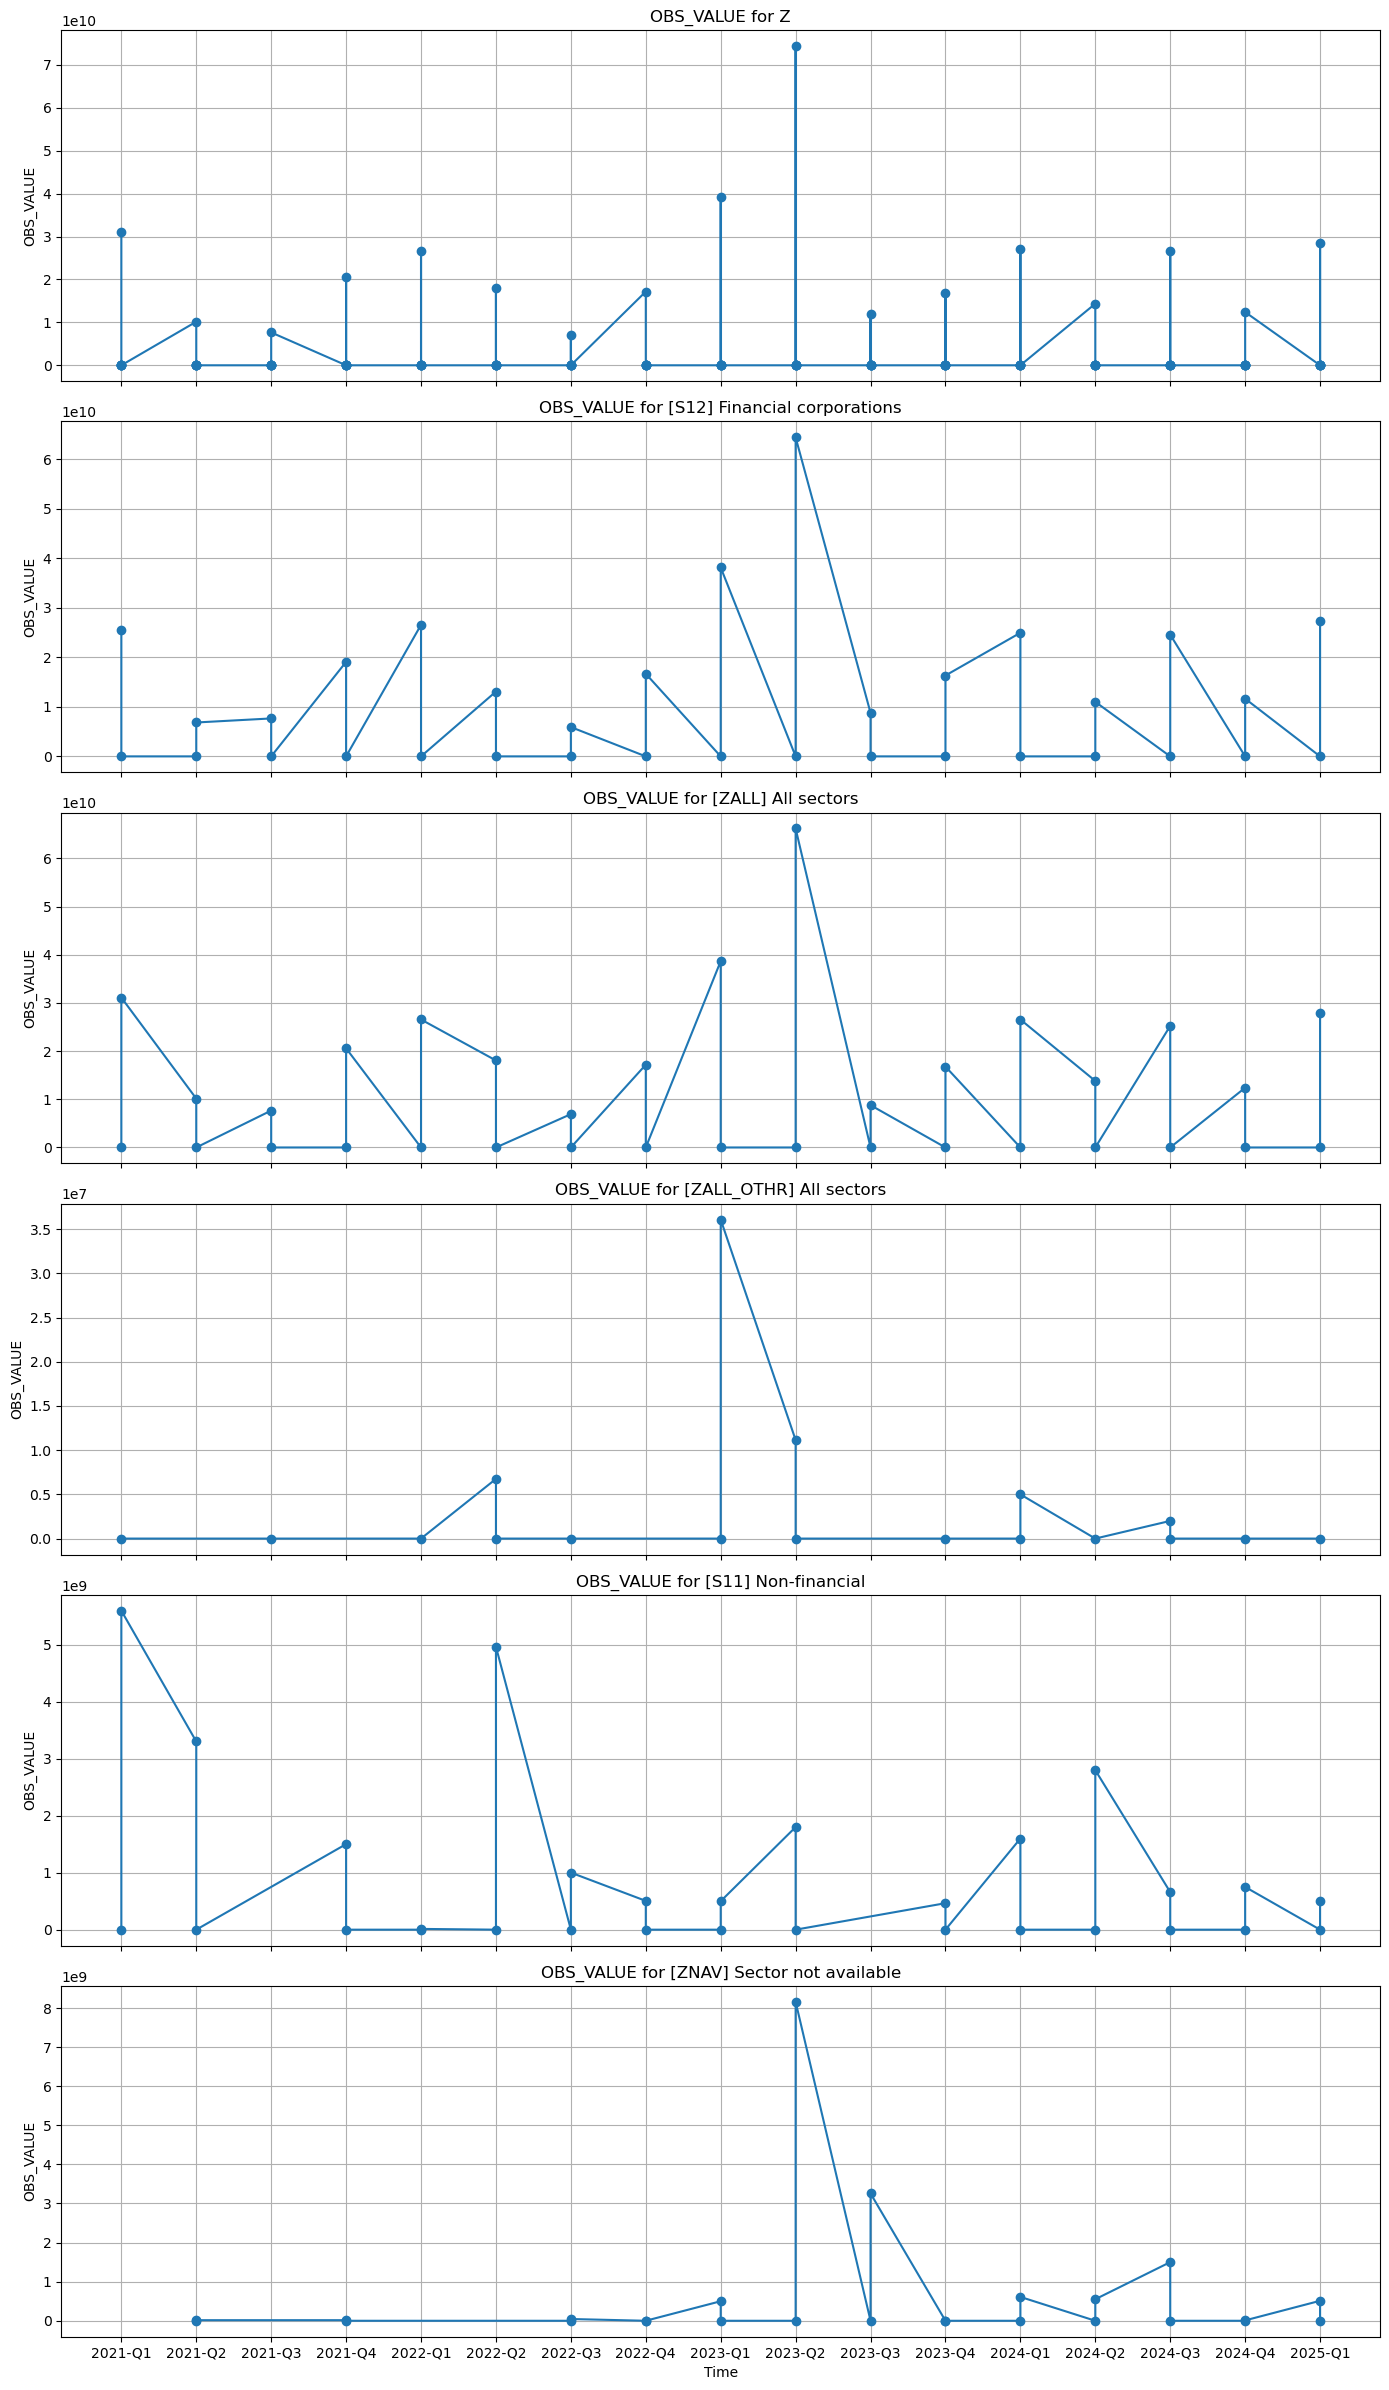

In [31]:
unique_sectors = df['ISSUER_SECTOR'].unique()
n_sectors = len(unique_sectors)
fig, axes = plt.subplots(n_sectors, 1, figsize=(14, 4 * n_sectors), sharex=True)
if n_sectors == 1:
    axes = [axes]
for ax, sector in zip(axes, unique_sectors):
    sector_df = df[df['ISSUER_SECTOR'] == sector].sort_values('TIME_PERIOD')
    ax.plot(sector_df['TIME_PERIOD'], sector_df['OBS_VALUE'], marker='o')
    ax.set_title(f'OBS_VALUE for {sector}')
    ax.set_ylabel('OBS_VALUE')
    ax.grid(True)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

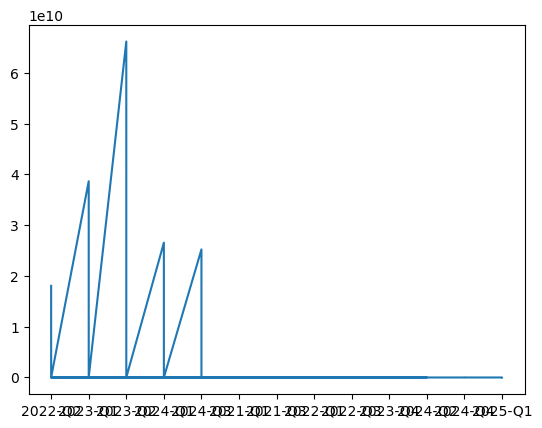

In [23]:
plt.plot(detailed_result_df['TIME_PERIOD'],detailed_result_df['OBS_VALUE'])